<a href="https://colab.research.google.com/github/dD2405/Intro_to_TensorFlow/blob/master/6_Transfer_Learning_with_TensorFlow_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Hub and Transfer Learning

[TensorFlow Hub](http://tensorflow.org/hub) is an online repository of already trained TensorFlow models that you can use.
These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

In this Colab we will do both.

Here, you can see all the models available in [TensorFlow Module Hub](https://tfhub.dev/).

## Concepts that will be covered in this Colab

1. Use a TensorFlow Hub model for prediction.
2. Use a TensorFlow Hub model for Dogs vs. Cats dataset.
3. Do simple transfer learning with TensorFlow Hub.

Before starting this Colab, you should reset the Colab environment by selecting `Runtime -> Reset all runtimes...` from menu above.

In [0]:
from __future__ import division, unicode_literals, absolute_import, print_function

In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [0]:
import logging
logger = tf.get_logger()

# This function sets the threshold of this logger to lvl. 
# This means that all the messages below this level will be ignored.
logger.setLevel(logging.ERROR)

# Part 1: Use a TensorFlow Hub MobileNet for prediction




In this part of the Colab, we'll take a trained model, load it into to Keras, and try it out.

The model that we'll use is MobileNet v2 (but any model from [tf2 compatible image classifier URL from tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification) would work).

## Download the classifier

Download the MobileNet model and create a Keras model from it.
MobileNet is expecting images of 224 $\times$ 224 pixels, in 3 color channels (RGB).

In [0]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))])

## Run it on a single image


MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms.
Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

65536/61306 [================================] - 0s 0us/step


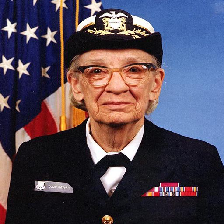

In [6]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES,IMAGE_RES))
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Remember, models always want a batch of images to process. So here, we add a batch dimension, and pass the image to the model for prediction.

In [8]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a military uniform or something else?

In [9]:
result[0]

array([ 0.17920303,  1.2696182 , -0.3149821 , ...,  0.6060541 ,
       -0.4299778 ,  0.11200593], dtype=float32)

In [10]:
# axis = -1 or axis = 0, both can be used to access the max value of column 
predicted_class = np.argmax(result[0], axis = -1)
predicted_class

653

## Decode the predictions

To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

16384/10484 [==============================================] - 0s 0us/step


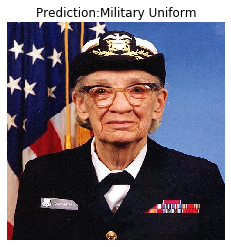

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class] 
_ = plt.title("Prediction:" + predicted_class_name.title())


# Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset

Now we'll use the full MobileNet model and see how it can perform on the Dogs vs. Cats dataset.

## Dataset

We can use TensorFlow Datasets to load the Dogs vs Cats dataset.

In [12]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [13]:
for i, example_image in enumerate(train_examples.take(5)):
    print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (500, 343, 3)
Image 2 shape: (375, 500, 3)
Image 3 shape: (375, 500, 3)
Image 4 shape: (150, 200, 3)
Image 5 shape: (375, 500, 3)


So we need to reformat all images to the resolution expected by MobileNet (224, 224).



The `.repeat()` and `steps_per_epoch` here is not required, but saves ~15s per epoch, since the shuffle-buffer only has to cold-start once.

In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Run the classifier on a batch of images

In [0]:
image_batch, label_batch = next(iter(train_batches.take(1)))

In [16]:
image_batch

<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0.28395486, 0.41728818, 0.5545431 ],
         [0.29120275, 0.42453608, 0.561791  ],
         [0.29816794, 0.4315013 , 0.56875616],
         ...,
         [0.733736  , 0.8317752 , 0.9180497 ],
         [0.72329307, 0.8213323 , 0.9076068 ],
         [0.7145395 , 0.81257874, 0.89885324]],

        [[0.29500175, 0.4283351 , 0.56559   ],
         [0.29846227, 0.4317956 , 0.5690505 ],
         [0.30316004, 0.43649337, 0.57374823],
         ...,
         [0.71587884, 0.81391805, 0.90019256],
         [0.711362  , 0.8094012 , 0.8956757 ],
         [0.70260847, 0.8006477 , 0.8869222 ]],

        [[0.3019608 , 0.43529412, 0.57254905],
         [0.30531237, 0.4386457 , 0.5759006 ],
         [0.3061841 , 0.43951744, 0.57677233],
         ...,
         [0.70603114, 0.80014884, 0.8942665 ],
         [0.69318974, 0.7873074 , 0.881425  ],
         [0.6881915 , 0.7823091 , 0.8764268 ]],

        ...,

        [[0.19054876, 0.32388213,

In [17]:
label_batch

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1])>

In [18]:
image_batch = image_batch.numpy()
image_batch

array([[[[0.28395486, 0.41728818, 0.5545431 ],
         [0.29120275, 0.42453608, 0.561791  ],
         [0.29816794, 0.4315013 , 0.56875616],
         ...,
         [0.733736  , 0.8317752 , 0.9180497 ],
         [0.72329307, 0.8213323 , 0.9076068 ],
         [0.7145395 , 0.81257874, 0.89885324]],

        [[0.29500175, 0.4283351 , 0.56559   ],
         [0.29846227, 0.4317956 , 0.5690505 ],
         [0.30316004, 0.43649337, 0.57374823],
         ...,
         [0.71587884, 0.81391805, 0.90019256],
         [0.711362  , 0.8094012 , 0.8956757 ],
         [0.70260847, 0.8006477 , 0.8869222 ]],

        [[0.3019608 , 0.43529412, 0.57254905],
         [0.30531237, 0.4386457 , 0.5759006 ],
         [0.3061841 , 0.43951744, 0.57677233],
         ...,
         [0.70603114, 0.80014884, 0.8942665 ],
         [0.69318974, 0.7873074 , 0.881425  ],
         [0.6881915 , 0.7823091 , 0.8764268 ]],

        ...,

        [[0.19054876, 0.32388213, 0.42976448],
         [0.1992384 , 0.33257174, 0.4384541 ]

In [19]:
label_batch = label_batch.numpy()
label_batch

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1])

In [21]:
result_batch = model.predict(image_batch)
result_batch

array([[ 0.1990965 , -0.24085103,  0.12692459, ..., -0.3168623 ,
         0.72859216, -0.4029018 ],
       [ 0.32043836, -1.2226881 , -0.26559916, ..., -0.1879771 ,
        -0.4370568 ,  2.0014653 ],
       [ 0.22088954,  0.19221118,  0.1708038 , ..., -1.6494409 ,
        -0.42362782,  0.42860615],
       ...,
       [ 0.21693745,  1.1423714 ,  2.1717303 , ..., -1.5975194 ,
         0.8460894 ,  2.1590915 ],
       [ 0.32158545, -2.1600237 , -0.9430509 , ..., -1.075087  ,
        -0.92479324,  0.8313093 ],
       [ 0.26635388, -0.07481293,  0.5237839 , ...,  0.21750998,
         0.54241014,  1.1203218 ]], dtype=float32)

Remember our `model` object is still the full MobileNet model trained on ImageNet, so it has 1000 possible output classes.
ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.


In [22]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Border collie', 'Leonberg', 'Maltese dog', 'giant schnauzer',
       'Egyptian cat', 'Egyptian cat', 'golden retriever',
       'English springer', 'tabby', 'Egyptian cat', 'Egyptian cat',
       'Egyptian cat', 'toy poodle', 'otterhound', 'Egyptian cat',
       'Persian cat', 'tabby', 'kelpie', 'bull mastiff', 'Cardigan',
       'Doberman', 'Chihuahua', 'Egyptian cat', 'kelpie', 'Rottweiler',
       'Egyptian cat', 'tabby', 'golden retriever', 'wallaby', 'doormat',
       'boxer', 'Shih-Tzu'], dtype='<U30')

The labels seem to match names of Dogs and Cats. Let's now plot the images from our Dogs vs Cats dataset and put the ImageNet labels next to them.

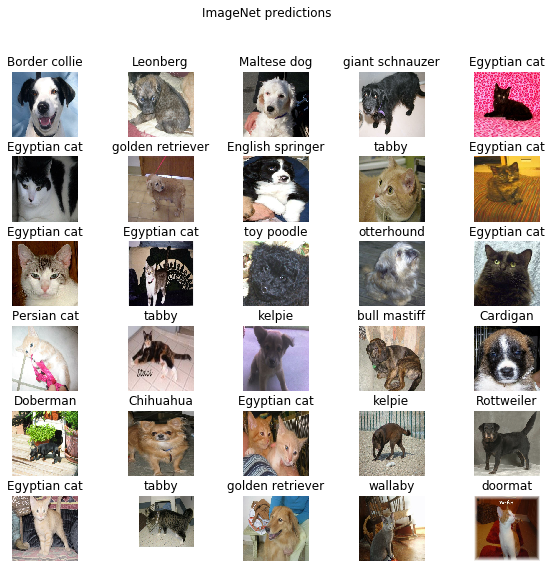

In [23]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Part 3: Do simple transfer learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. We will continue using MobileNet v2 because in later parts of this course, we will take this model and deploy it on a mobile device using [TensorFlow Lite](https://www.tensorflow.org/lite). Any [image feature vector URL from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) would work here.

We'll also continue to use the Dogs vs Cats dataset, so we will be able to compare the performance of this model against the ones we created from scratch earlier.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a `feature_extractor`. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

Let's run a batch of images through this, and see the final shape. 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [26]:
feature_batch = feature_extractor(image_batch)
print(feature_batch)

tf.Tensor(
[[0.01219338 0.         1.2486548  ... 0.04154803 0.         1.0847272 ]
 [0.01255148 0.         0.         ... 0.5257736  0.1361932  1.7865124 ]
 [0.18367517 1.8202925  0.30302846 ... 0.46932805 0.         0.01742637]
 ...
 [0.04800476 0.         0.19025753 ... 0.         0.         0.06220006]
 [0.         0.26558185 1.4634277  ... 1.3180302  0.09968463 0.06836051]
 [0.07662144 2.6950285  0.         ... 0.05915034 0.         0.        ]], shape=(32, 1280), dtype=float32)


Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [0]:
feature_extractor.trainable = False

## Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [29]:
model = tf.keras.Sequential([feature_extractor, layers.Dense(2, activation='softmax')])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

We now train this model like any other, by first calling `compile` followed by `fit`.

In [31]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches, validation_data=validation_batches, epochs=EPOCHS )

Epoch 1/6
582/582 [==============================] - 48s 83ms/step - loss: 0.0555 - accuracy: 0.9806 - val_loss: 0.0333 - val_accuracy: 0.9873
Epoch 2/6
582/582 [==============================] - 45s 77ms/step - loss: 0.0303 - accuracy: 0.9903 - val_loss: 0.0333 - val_accuracy: 0.9884
Epoch 3/6
582/582 [==============================] - 44s 76ms/step - loss: 0.0261 - accuracy: 0.9914 - val_loss: 0.0290 - val_accuracy: 0.9897
Epoch 4/6
582/582 [==============================] - 43s 75ms/step - loss: 0.0220 - accuracy: 0.9924 - val_loss: 0.0308 - val_accuracy: 0.9892
Epoch 5/6
582/582 [==============================] - 44s 76ms/step - loss: 0.0208 - accuracy: 0.9924 - val_loss: 0.0315 - val_accuracy: 0.9877
Epoch 6/6
582/582 [==============================] - 44s 75ms/step - loss: 0.0171 - accuracy: 0.9950 - val_loss: 0.0406 - val_accuracy: 0.9864


You can see we get ~98% validation accuracy, which is absolutely awesome. This is a huge improvement over the model we created in the previous lesson, where we were able to get ~83% accuracy. The reason for this difference is that MobileNet was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).

Although not equivalent to TensorFlow Hub, you can check out how to create MobileNet in Keras [here](https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet.py).

Let's plot the training and validation accuracy/loss graphs.

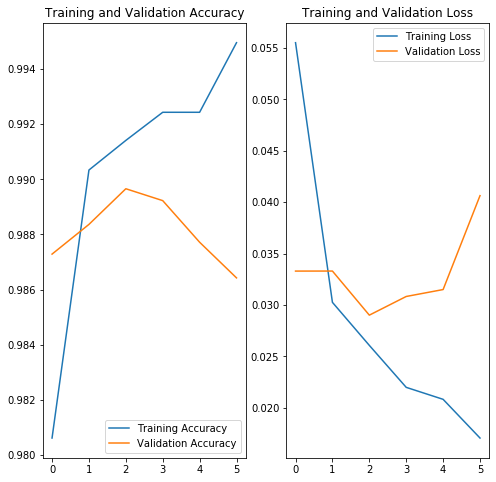

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()